# Starter Notebook

## Importing Libraries

In [1]:
#P100 GPU 

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l1_l2, l1, l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Initializing Parameters

In [3]:
# import os
# os.listdir('../input/tuberculosis-tb-chest-x-ray-cleaned-database/TB Chest Radiography Database/Partitioned Data/Cleaned Data')

In [4]:
IMAGE_SIZE = [256, 256, 3]
target_size = (256, 256)
epochs = 50
Batch = 16

# train_path = 'Dataset/TB Chest Radiography Database/TB Chest Radiography Database/Partitioned Data/Cleaned Data/Train'
# test_path = 'Dataset/TB Chest Radiography Database/TB Chest Radiography Database/Partitioned Data/Cleaned Data/Test'
# val_path = 'Dataset/TB Chest Radiography Database/TB Chest Radiography Database/Partitioned Data/Cleaned Data/Val'


# train_path = 'Dataset/Merge data/dataset/Train'
# test_path = 'Dataset/Merge data/dataset/Test'
# val_path = 'Dataset/Merge data/dataset/Val'

# train_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/preprocess init data/Train'
# test_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/preprocess init data/Test'
# val_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/preprocess init data/Validation'


# train_path = 'Dataset/Merge data/preprocess data/dataset 1/Train'
# test_path = 'Dataset/Merge data/preprocess data/dataset 1/Test'
# val_path = 'Dataset/Merge data/preprocess data/dataset 1/Val'

# train_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/init data - Copy/Train'
# test_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/init data - Copy/Test'
# val_path ='Dataset/icddr, b/Final png images/500,500 px/gray Dataset/init data - Copy/Validation'

train_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/update init data/Train'
test_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/update init data/Test'
val_path = 'Dataset/icddr, b/Final png images/500,500 px/gray Dataset/update init data/Validation'

## Data Augmentation

In [5]:
train_datagen = ImageDataGenerator( 
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift the width
    height_shift_range=0.1,  # Randomly shift the height
    shear_range=0.2,  # Shear transformation
    zoom_range=0.1,  # Randomly zoom in
    horizontal_flip=True,  # Randomly flip horizontally
    fill_mode='nearest'  # Fill missing pixels with the nearest value
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = target_size,
                                                 batch_size = Batch,                                            
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(val_path,
                                            target_size = target_size,
                                            batch_size = Batch,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = target_size,
                                            batch_size = Batch,
                                            class_mode = 'categorical',
                                           shuffle=False)

Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## Setting Base Model

In [6]:
base_model = Xception(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False, pooling='max')

In [7]:

# base_model.trainable = True

# set_trainable = False

# for layer in base_model.layers:
#     if layer.name == 'block14*':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable=False
        
# for layer in base_model.layers:
#     print(layer.name, layer.trainable)

for layer in base_model.layers:
    layer.trainable = False

In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

## Building Model

In [9]:
# x = base_model.output
# x = Flatten()(x)

# x = Dropout(0.2)(x)

# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# # x = Dropout(0.2)(x)  # it made more complex

# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# prediction = Dense(2, activation='softmax')(x)

# final_model = Model(inputs=base_model.input, outputs=prediction)

In [10]:
x = base_model.output
x = Flatten()(x)

x = Dropout(0.2)(x)

x = Dense(1024, activation='LeakyReLU')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(512, activation='LeakyReLU')(x)
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)  # it made more complex

x = Dense(256, activation='LeakyReLU')(x)
x = Dense(128, activation='LeakyReLU')(x)
x = Dense(64, activation='LeakyReLU')(x)
prediction = Dense(2, activation='softmax')(x)

final_model = Model(inputs=base_model.input, outputs=prediction)

In [11]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

                                                                                                  
 dense_5 (Dense)                (None, 2)            130         ['dense_4[0][0]']                
                                                                                                  
Total params: 23,663,210
Trainable params: 2,798,658
Non-trainable params: 20,864,552
__________________________________________________________________________________________________


## Optimization

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2)

early = EarlyStopping(monitor='loss', patience=3)

## Compiling Model

In [13]:
final_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Training

In [14]:

history = final_model.fit(
    training_set,
    validation_data=val_set,
    epochs=40,
    callbacks=[reduce_lr, early]
)

Epoch 1/40
9/9 [==============================] - 11s 558ms/step - loss: 0.8243 - accuracy: 0.6857 - val_loss: 2.1590 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
9/9 [==============================] - 2s 242ms/step - loss: 0.4189 - accuracy: 0.8357 - val_loss: 1.4804 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/40
9/9 [==============================] - 2s 244ms/step - loss: 0.5150 - accuracy: 0.7500 - val_loss: 1.5630 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/40
9/9 [==============================] - 2s 240ms/step - loss: 0.3172 - accuracy: 0.8571 - val_loss: 0.8485 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/40
9/9 [==============================] - 2s 239ms/step - loss: 0.2711 - accuracy: 0.8786 - val_loss: 0.4670 - val_accuracy: 0.8667 - lr: 5.0000e-04
Epoch 6/40
9/9 [==============================] - 2s 243ms/step - loss: 0.3419 - accuracy: 0.8500 - val_loss: 0.5490 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 7/40
9/9 [==============================] - 2s 245ms/step - loss: 0

## Evaluating Model

In [15]:
print("Evaluating on test data ....")
results = final_model.evaluate(test_set, batch_size=Batch)
print("test loss, test acc:", results)

Evaluating on test data ....
2/2 [==============================] - 0s 114ms/step - loss: 0.1506 - accuracy: 0.9333
test loss, test acc: [0.1505754441022873, 0.9333333373069763]


## Saving History

In [16]:
#history.history

## Plotting Curves

In [17]:
def plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    fig.show()

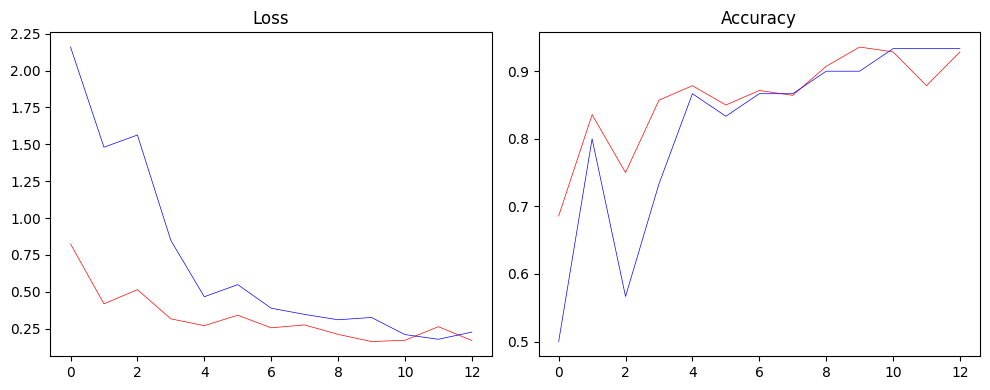

In [18]:
plot(history.history)

### Accuracy vs Epochs

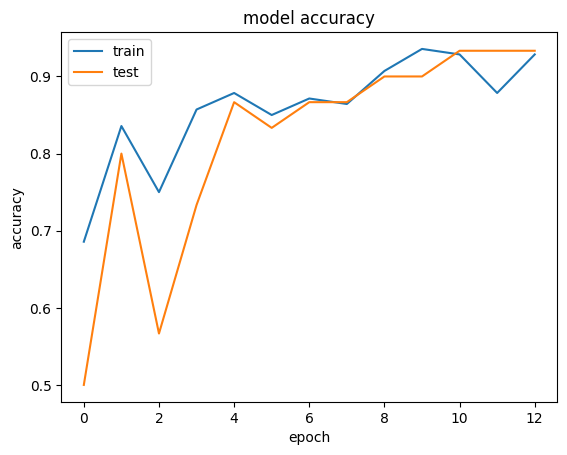

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Loss vs Epochs

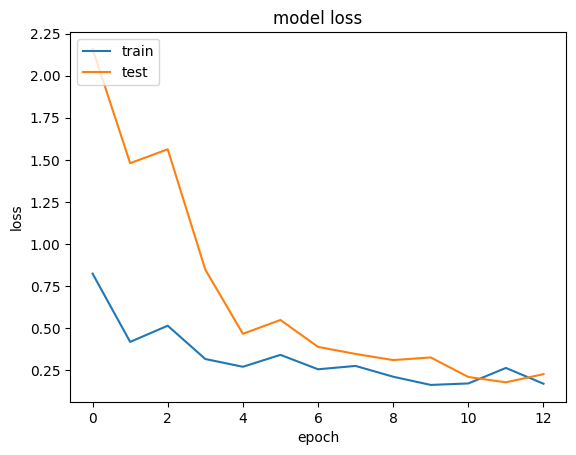

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Confusion Matrix

In [21]:
Y_pred = np.argmax(final_model.predict_generator(test_set), axis=1)
Y_test = test_set.classes

In [22]:
cm = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix : \n', cm)

Confusion Matrix : 
 [[15  0]
 [ 2 13]]


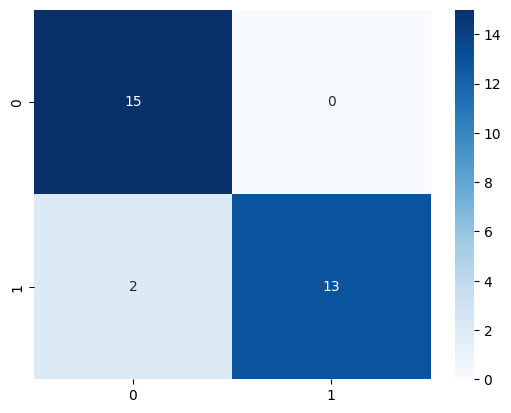

In [23]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), cmap="Blues", annot=True,fmt="d")

### Classification Report

In [24]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.87      0.93        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



### AUC-ROC

ROC AUC score: 0.9333333333333333


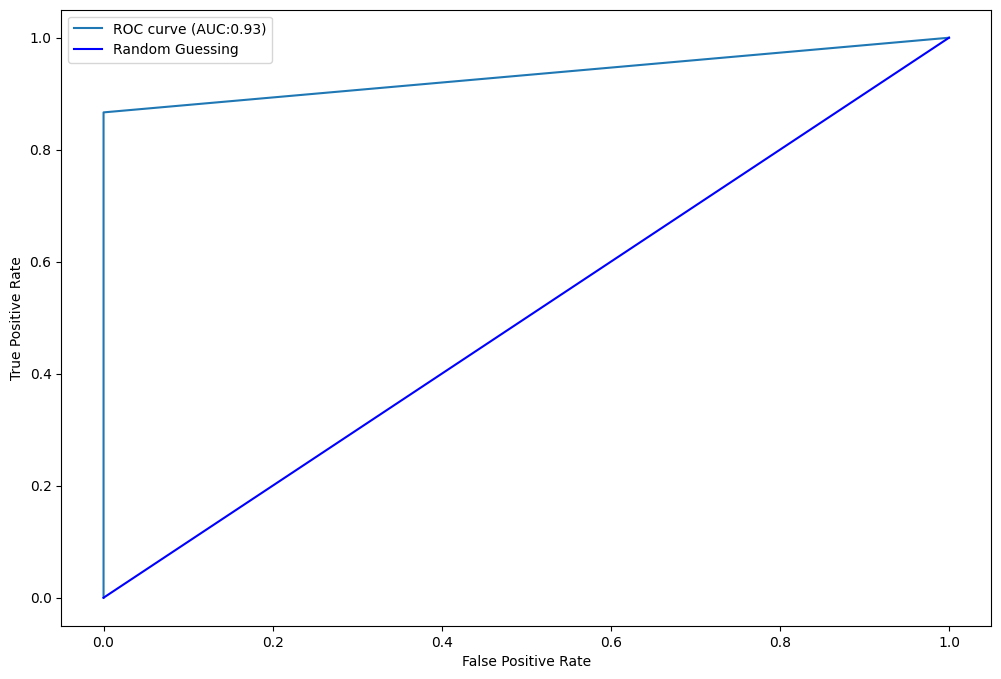

In [25]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['ROC curve']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

### Curves with Seaborn Styling

In [26]:
from sklearn.metrics import roc_auc_score

auc_value = roc_auc_score(Y_test, Y_pred)

In [27]:
auc_value

0.9333333333333333

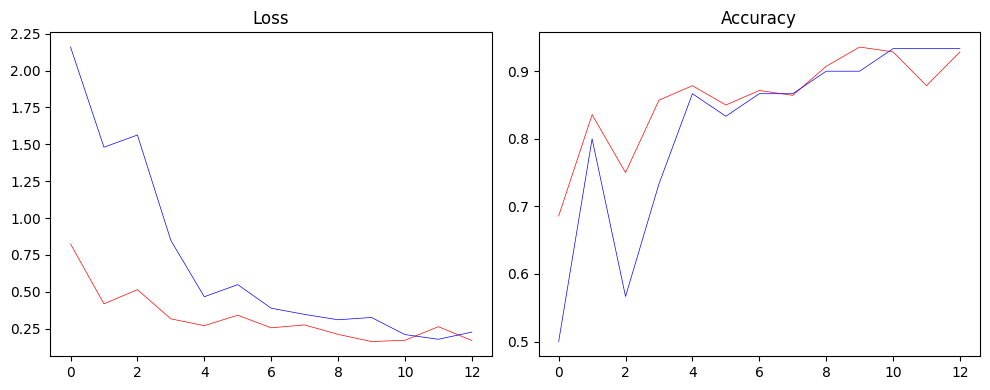

In [28]:
plot(history.history)

### test x-rays


In [29]:
from tensorflow.keras.preprocessing import image

img = image.load_img("TB7.bmp", target_size=(256,256))              
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array = img_array / 255.0  

pred = final_model.predict(img_array)
pred

1/1 [==============================] - 1s 1s/step


array([[0.15531117, 0.84468883]], dtype=float32)

#### np.argmax(pred)

In [30]:
# if pred >= 0.5:
#     print('1')
# else:
#     print('0')

In [31]:

# if np.argmax(pred)==0:
#     print("Tuberculosis Negative")
# else:
#     print("Tuberculosis positive")

In [32]:
# import pickle
# # Save the model to a file using pickle
# with open('xception_model.pkl', 'wb') as file:
#     pickle.dump(final_model, file)

In [33]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the folder containing images
folder_path = 'ForTest/'

# List all files in the folder
image_files = os.listdir(folder_path)

for file_name in image_files:
    # Construct the complete file path
    file_path = os.path.join(folder_path, file_name)
    
    # Load and preprocess each image
    img = image.load_img(file_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array / 255.0  # Normalize
    
    # Perform further processing or prediction with the img_array
    # Example: model.predict(img_array) if you have a model for predictions
    print(file_name)
    pred = final_model.predict(img_array)
    
    if np.argmax(pred)==0:
        print("\t Tuberculosis Negative")
    else:
        print("\t Tuberculosis positive")


NORMAL1.png
1/1 [==============================] - 0s 25ms/step
	 Tuberculosis Negative
NORMAL10.png
1/1 [==============================] - 0s 23ms/step
	 Tuberculosis Negative
NORMAL11.png
1/1 [==============================] - 0s 27ms/step
	 Tuberculosis Negative
NORMAL2.png
1/1 [==============================] - 0s 24ms/step
	 Tuberculosis positive
NORMAL3.png
1/1 [==============================] - 0s 26ms/step
	 Tuberculosis positive
NORMAL4.png
1/1 [==============================] - 0s 23ms/step
	 Tuberculosis positive
NORMAL5.png
1/1 [==============================] - 0s 25ms/step
	 Tuberculosis Negative
NORMAL6.png
1/1 [==============================] - 0s 23ms/step
	 Tuberculosis Negative
NORMAL7.png
1/1 [==============================] - 0s 23ms/step
	 Tuberculosis Negative
NORMAL8.png
1/1 [==============================] - 0s 23ms/step
	 Tuberculosis Negative
NORMAL9.png
1/1 [==============================] - 0s 22ms/step
	 Tuberculosis Negative
TB1.bmp
1/1 [=================